In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import * 

# Escape the maze

You start in the green state shown below and your goal is to find a strategy that takes you to one of goal states (red) as fast as possible. In general, you have four actions available, you can go up, down, to the left, or to the right. Every action yields reward -1, unless it brings you to one of the goal states in which case the reward is +10.

[simplemaze.png](attachment:simplemaze.png)

<div>
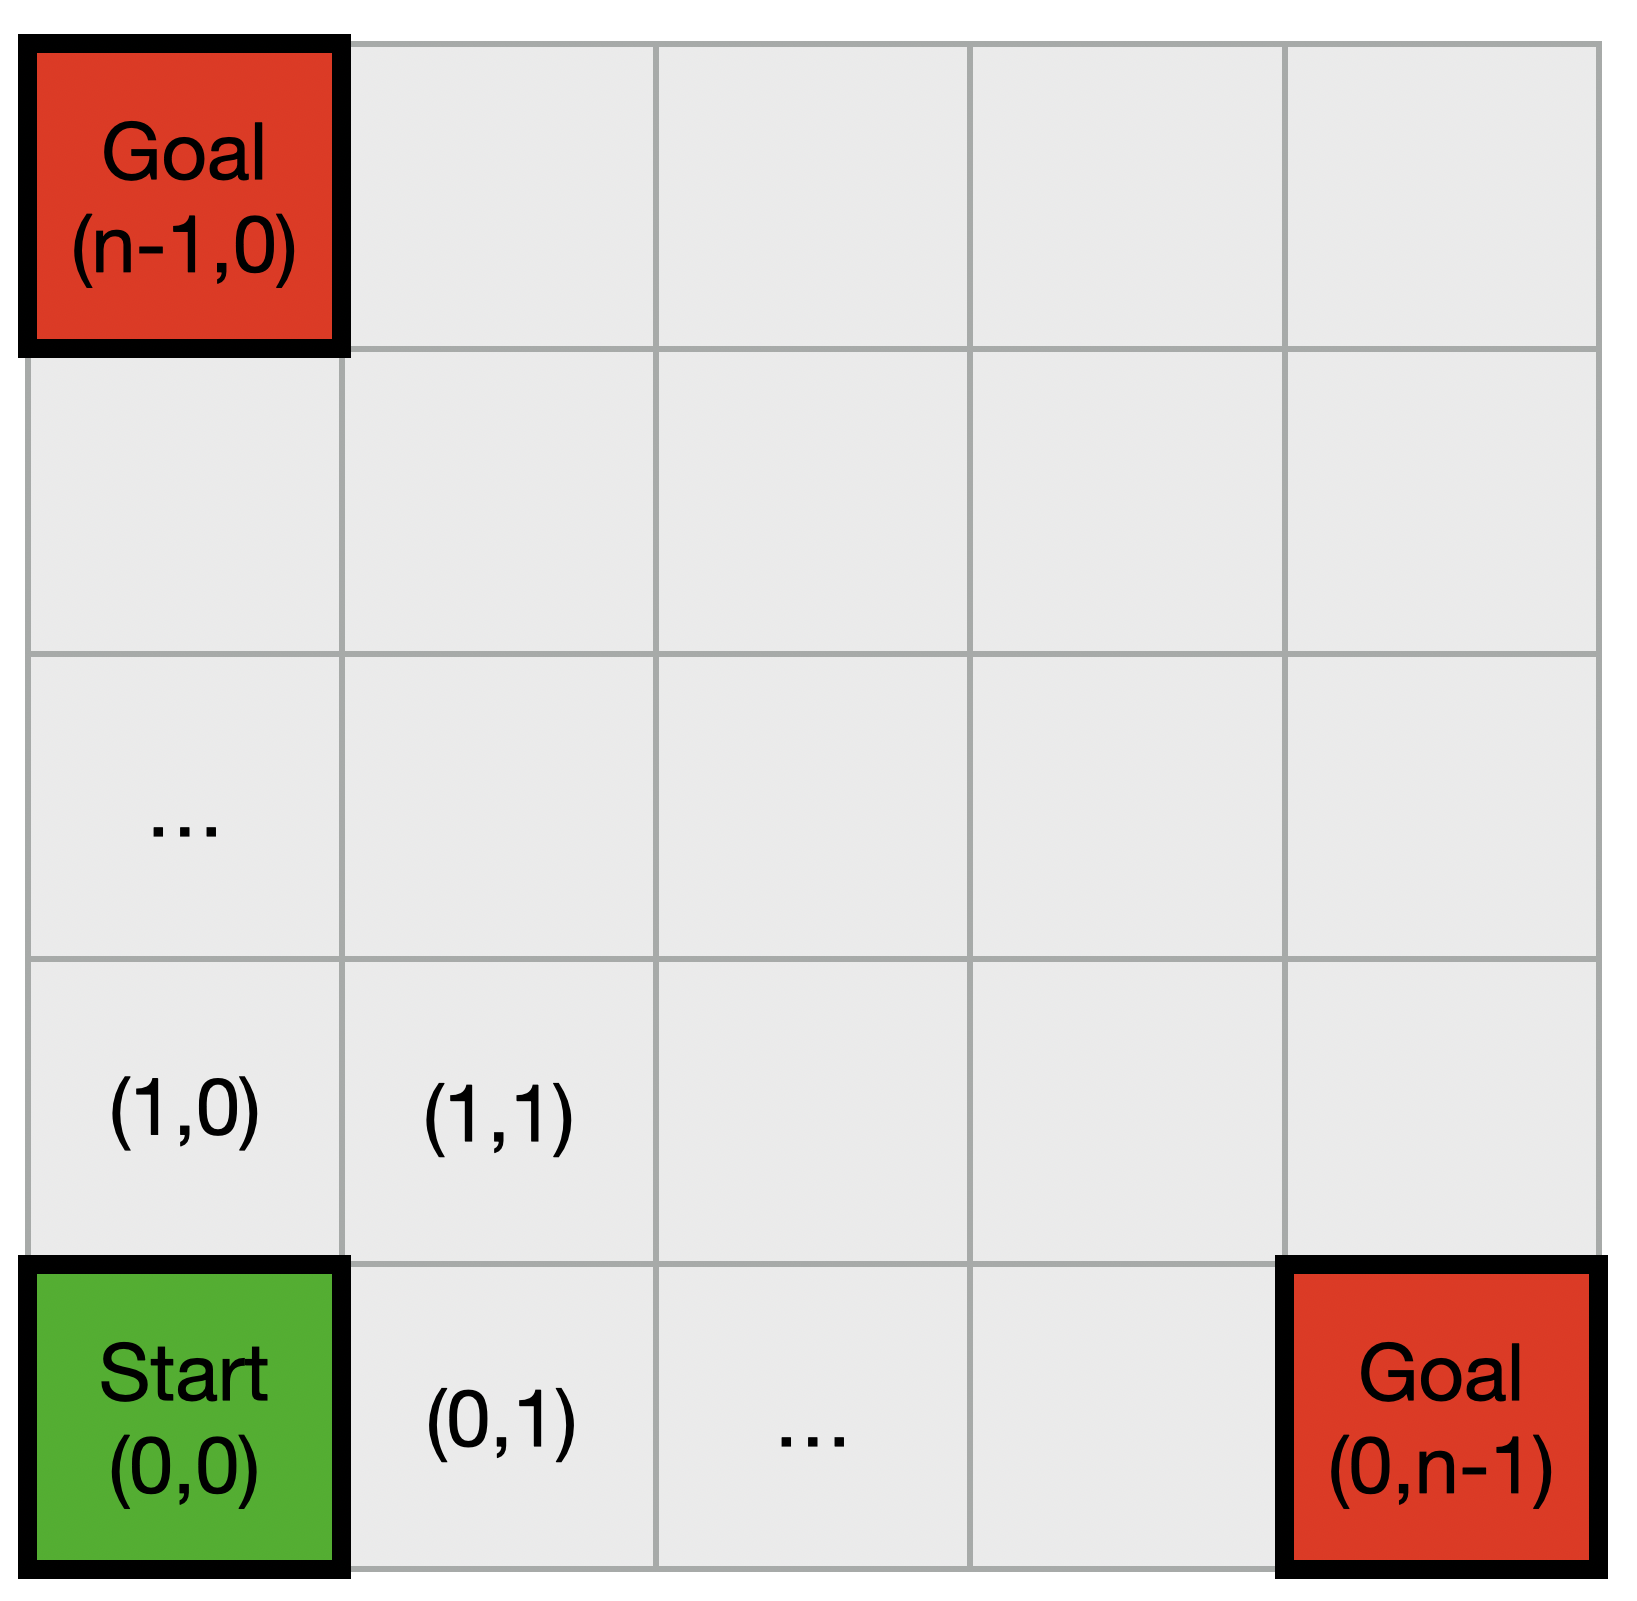
<div>

utils.py provide the maze environment and some methods. Your task is to code the following Q-table update rules:
- in Part 1, the iterative update rule 
- in Part 2, the SARSA update rule
- in Part 3, the SARSA($\lambda$) update rule

and to answer the related questions. 

### Part 0. Simulating the game 

In this part, we just want to understand how this simple maze works. Therefore, we will not update the Q-table (equivalently, we will not improve the policy here), but we will just take a random walk in the maze.

In [2]:
n = 3 # size of the maze 
env = Maze(n) # creating the maze environment

Q_table = np.zeros((env.n_states, env.n_actions))
state = env.current_state

num_episodes = 1

action_dict = {0:'down', 1:'right', 2:'up', 3:'left'}

for itr in range(num_episodes): 
    while not env.done:
        state_ind = cell_to_ind(state, n) # switches between two types of encoding of the states
        action = pick_action(state, Q_table) # randomly chooses one direction to go
        next_state, reward, done = env.step(action) # observes the next state and reward
        print('state:', state, 'action:', action_dict[action], '-> You received reward', reward)
        if state==next_state:
            print('Oops, you ran into the wall! You stay in the same state.')
        state = next_state
    
    print('You are in the goal state! Start over.')
    env.reset()
    state = env.current_state

state: (0, 0) action: down -> You received reward -1
Oops, you ran into the wall! You stay in the same state.
state: (0, 0) action: right -> You received reward -1
state: (0, 1) action: right -> You received reward 10
You are in the goal state! Start over.


### Part 1. Iterative Update Rule

In this part, we will implement an iterative update rule we learned in the class: $\Delta Q(s,a) = \eta (r - Q(s,a))$ which is used for bandit problems. We will observe the state values of the so-called V-table that satisfies $V(s) = \max_a Q(s,a)$. The values of the V-table reflect goodness of the states as opposed to the goodness of the state-action pairs in the Q-table.

Questions: 
- Code the update rule in the space indicated below. 
- Does the V-table seem to converge in 100 episodes? What if you increase the number of iterations? Comment on the V-table at convergence (training for 1000 episodes). 
- Does the agent learn to escape the maze? (Check if the rewards increase over time.)

[[ 0.          7.45813417 -0.468559   -0.5217031  -0.56953279]
 [ 9.774716   -0.61257951 -0.65132156 -0.61257951 -0.56953279]
 [-0.94766524 -0.92023356 -0.83322818 -0.65132156 -0.468559  ]
 [-0.99820299 -0.98802748 -0.91137062 -0.56953279  7.71232075]
 [-0.99999074 -0.99800332 -0.94185026  9.7972444   0.        ]]


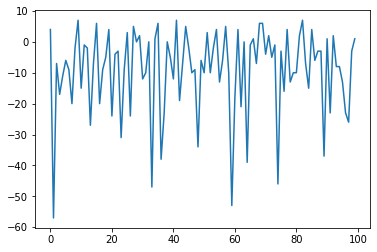

In [3]:
n = 5 
env = Maze(n)

Q_table = np.zeros((env.n_states, env.n_actions))
state = env.current_state
eta = 0.1 # learning rate 

num_episodes = 100
rewards = np.zeros(num_episodes)

for itr in range(num_episodes):
    
    while not env.done:
        state_ind = cell_to_ind(state, n)
        action = pick_action(state, Q_table)
        next_state, reward, done = env.step(action)

        ######## code here #############################
        # update Q-table using the iterative update rule

        Q_table[state_ind, action] += eta * (reward - Q_table[state_ind, action])
        
        ######## code here ############################
        rewards[itr] += reward

        state = next_state
    
    env.reset()
    state = env.current_state

        
print(calc_V(Q_table))
plt.plot(rewards)

### Part 2. SARSA

In this part, we will implement the SARSA update rule we learned in class: $\Delta Q(s,a) = \eta (r + \gamma Q(s',a') - Q(s,a))$.  

Questions:
- Code the update rule in the space indicated below. 
- Does the agent now learn the task? Why does the one-step update rule fail? 
- Comment on the V-values at convergence, do all the state values make sense?
- *pick_action* has a parameter $\epsilon \in [0, 1]$ that balances exploitative with exploratory behavior of the agent. So far the agent was purely exploitative, i.e., it was always choosing action $a := arg\max_{a} Q(s, a)$, but in general for each step the agent with probability $\epsilon$ picks a random action (to explore new states/actions). If you add some exploration ($\epsilon \neq 0$), how do the V-table and the reward curve change?

[[ 0.          1.         -0.1        -0.1         0.        ]
 [ 9.99905954 -0.1        -0.109      -0.1        -0.1       ]
 [ 7.99097157 -0.19       -0.19        0.          0.        ]
 [ 6.15679208 -0.361      -0.19        0.          1.9       ]
 [ 4.44235136 -0.46363241  1.41385169  6.12579511  0.        ]]


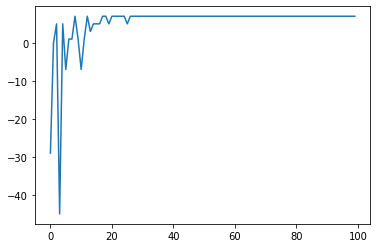

In [4]:
n = 5 
env = Maze(n)

Q_table = np.zeros((env.n_states, env.n_actions))
state = env.current_state
eta = 0.1 # learning rate 
gamma = 0.9 # discount rate
eps = 0 # exploration rate 

num_episodes = 100
rewards = np.zeros(num_episodes)

for itr in range(num_episodes):
    
    action = pick_action(state, Q_table, epsilon=eps)
    
    while not env.done:
        state_ind = cell_to_ind(state, n)
        next_state, reward, done = env.step(action)
        next_state_ind = cell_to_ind(next_state, n)
        next_action = pick_action(next_state, Q_table, epsilon=eps)

        ######## code here #############################
        # update Q-table using the iterative update rule
        
        Q_table[state_ind, action] += eta * (reward + gamma * Q_table[next_state_ind, next_action] - Q_table[state_ind, action])
    
        ######## code here ############################
        rewards[itr] += reward

        state = next_state
        action = next_action
    
    env.reset()
    state = env.current_state
        
print(calc_V(Q_table, epsilon=eps))
plt.plot(rewards)

### Part 3. SARSA($\lambda$)

In this part, we will work with a larger maze of size 15. To solve this task, you will implement the SARSA($\lambda$) update rule which uses eligibility traces: $\Delta Q = \eta (r + \gamma Q(s',a') - Q(s,a))*E$, where E is the table of eligibility traces, which is updated as follows:
$E = E*\lambda$ for the entire table and $E(s,a) = E(s,a) + 1$ for the current state-action pair.

Questions:
- Code the update rule in the space indicated below. 
- Compare the SARSA(0) and SARSA($\lambda$) for $\lambda=0.9$. Which of these learn to solve the task faster? Why?
Note: SARSA(0) is exactly equivalent to SARSA.

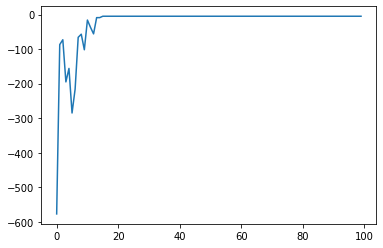

In [5]:
n = 15 
env = Maze(n)

Q_table = np.zeros((env.n_states, env.n_actions))
eligibility_table = np.zeros((env.n_states, env.n_actions))
state = env.current_state
eta = 0.1 # learning rate 
gamma = 0.9 # discount rate
lambd = 0.9 # eligibility decay rate

num_episodes = 100
rewards = np.zeros(num_episodes)

for itr in range(num_episodes):
    
    action = pick_action(state, Q_table)
    
    while not env.done:
        state_ind = cell_to_ind(state, n)
        next_state, reward, done = env.step(action)
        next_state_ind = cell_to_ind(next_state, n)
        next_action = pick_action(next_state, Q_table)

        ######## code here #############################
        # update Q-table using the iterative update rule
        
        eligibility_table *= lambd
        eligibility_table[state_ind, action] += 1
        
        Q_table += eta * (reward + gamma * Q_table[next_state_ind, next_action] - Q_table[state_ind, action]) * eligibility_table 

        ######## code here ############################
        rewards[itr] += reward

        state = next_state
        action = next_action
    
    env.reset()
    state = env.current_state
    eligibility_table.fill(0)

plt.plot(rewards)